In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense
import joblib

In [2]:
def fetch_stock_data(ticker, start='2010-01-01', end=None):
    if end is None:
        end = pd.Timestamp.today().strftime('%Y-%m-%d')
    df = yf.download(ticker, start=start, end=end)
    return df

In [3]:
def prepare_data(df, feature='Close', look_back=60):
    data = df[feature].values.reshape(-1, 1)
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data)
    X, y = [], []
    for i in range(look_back, len(scaled_data)):
        X.append(scaled_data[i-look_back:i, 0])
        y.append(scaled_data[i, 0])
    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    return X, y, scaler

In [4]:
def train_lstm(X_train, y_train, epochs=20, batch_size=32):
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(LSTM(units=50))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)
    return model


In [5]:
def predict_and_evaluate(model, X, y, scaler):
    y_pred = model.predict(X)
    y_pred_rescaled = scaler.inverse_transform(y_pred)
    y_true_rescaled = scaler.inverse_transform(y.reshape(-1, 1))
    rmse = np.sqrt(mean_squared_error(y_true_rescaled, y_pred_rescaled))
    mae = mean_absolute_error(y_true_rescaled, y_pred_rescaled)
    r2 = r2_score(y_true_rescaled, y_pred_rescaled)
    return y_true_rescaled, y_pred_rescaled, rmse, mae, r2

In [6]:
def forecast_next_year(model, data, scaler, look_back=60, days=365):
    last_sequence = data[-look_back:].reshape(1, look_back, 1)
    forecast_scaled = []
    for _ in range(days):
        pred = model.predict(last_sequence)
        forecast_scaled.append(pred[0,0])
        last_sequence = np.concatenate([last_sequence[:,1:,:], pred.reshape(1,1,1)], axis=1)
    forecast = scaler.inverse_transform(np.array(forecast_scaled).reshape(-1, 1))
    return forecast

In [7]:
def plot_predictions(y_true, y_pred, title='LSTM Stock Price Prediction'):
    plt.figure(figsize=(12,6))
    plt.plot(y_true, color='blue', label='Actual Price')
    plt.plot(y_pred, color='red', label='Predicted Price')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.show()


In [8]:
def plot_forecast(forecast, start_date):
    future_dates = pd.date_range(start=start_date, periods=len(forecast), freq='B')
    plt.figure(figsize=(12,6))
    plt.plot(future_dates, forecast, color='green', label='Forecasted Price')
    plt.title('LSTM 1-Year Tesla (TSLA) Stock Price Forecast')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

In [9]:
if __name__ == "__main__":
    ticker = "TSLA"
    df = fetch_stock_data(ticker)
    look_back = 60

    # Prepare data
    X, y, scaler = prepare_data(df, 'Close', look_back)
    split = int(len(X)*0.8)
    X_train, y_train = X[:split], y[:split]
    X_test, y_test = X[split:], y[split:]

    # Train LSTM
    model = train_lstm(X_train, y_train, epochs=20)

    # Evaluate
    y_true, y_pred, rmse, mae, r2 = predict_and_evaluate(model, X_test, y_test, scaler)
    print(f"RMSE: {rmse:.2f}, MAE: {mae:.2f}, R2: {r2:.2f}")

Epoch 1/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - loss: 0.0027
Epoch 2/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - loss: 4.6851e-04
Epoch 3/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - loss: 3.9435e-04
Epoch 4/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 3.4316e-04
Epoch 5/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 3.5418e-04
Epoch 6/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 3.1641e-04
Epoch 7/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - loss: 2.5458e-04
Epoch 8/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 2.7184e-04
Epoch 9/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - loss: 2.3022e-04
Epoch 10/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 2.8478e-04
Epoch 11/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - loss: 2.0177e-04
Epoch 12/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - loss: 2.0933e-04
Epoch 13/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - loss: 1.8580e-04
Epoch 14/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - loss: 1.5781e-04
Epoch 15/20
95/95 

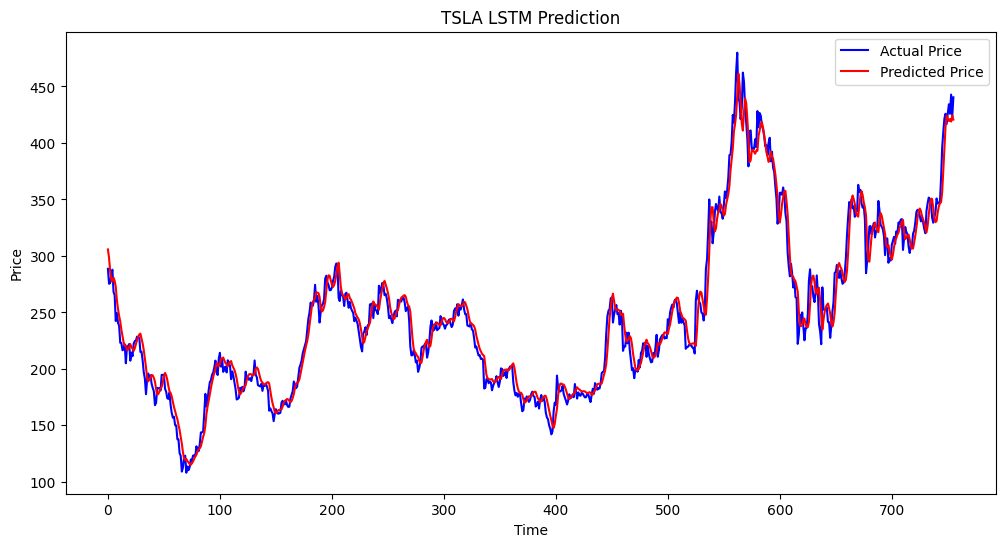

In [15]:
# Visualization
plot_predictions(y_true, y_pred, title=f'{ticker} LSTM Prediction')


In [16]:
# Save model and scaler
model.save("lstm_tsla_stock_model.h5")
joblib.dump(scaler, "tsla_scaler.save")

['tsla_scaler.save']

In [12]:
# Forecast for next 1 year
full_scaled_data = scaler.transform(df['Close'].values.reshape(-1, 1))
forecast = forecast_next_year(model, full_scaled_data, scaler, look_back=look_back, days=365)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━

In [13]:
# Save exact forecasted prices with dates
start_date = pd.Timestamp.today()
future_dates = pd.date_range(start=start_date, periods=365, freq='B')
df_forecast = pd.DataFrame({'Date': future_dates, 'Forecasted_Price': forecast.flatten().tolist()})
df_forecast.to_csv("tsla_lstm_1year_forecast.csv", index=False)

                        Date  Forecasted_Price
0 2025-09-29 21:05:06.144169        423.878540
1 2025-09-30 21:05:06.144169        420.187469
2 2025-10-01 21:05:06.144169        414.483032
3 2025-10-02 21:05:06.144169        408.277039
4 2025-10-03 21:05:06.144169        402.111389


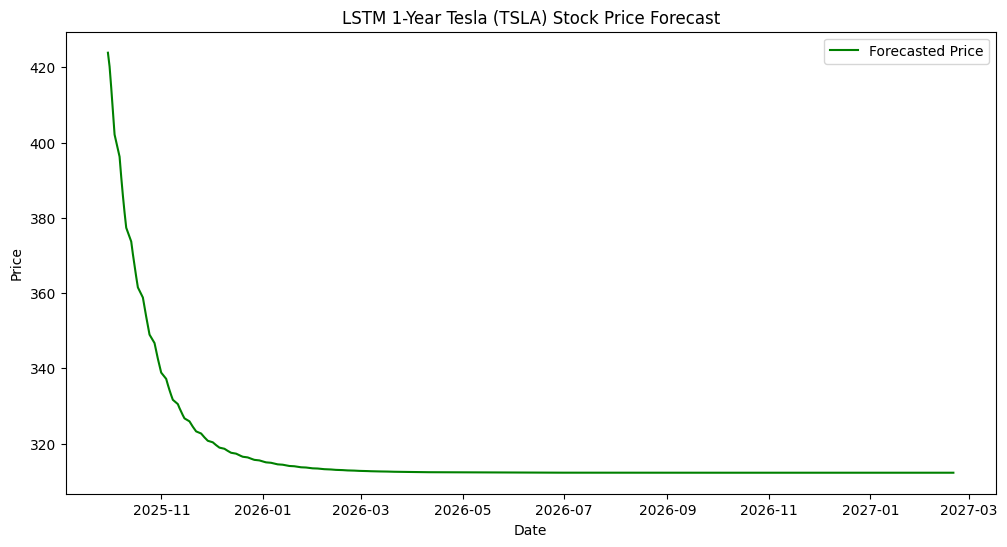

In [14]:
print(df_forecast.head())
plot_forecast(forecast, start_date=start_date)